In [23]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import cv2

ModuleNotFoundError: No module named 'models'

In [7]:
# Set some parameters
im_width = 128
im_height = 128
border = 5
train_img=[]
train_mask=[]

In [8]:
train = open("../VOC_2011_TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train_2.txt", 'r')
lines = train.readlines()
for i, line in enumerate(lines):
    train_img.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/JPEGImages/"+line.split('\n')[0]+".jpg")
    train_mask.append("../VOC_2011_TrainVal/VOCdevkit/VOC2011/SegmentationClass/"+line.split('\n')[0]+".png")
train.close()

In [9]:
a =cv2.imread(train_img[0])
a.shape

(281, 500, 3)

In [10]:
# Get and resize train images and masks
def get_data(img_path_list, mask_path_list, train=True):
    X = np.zeros((len(img_path_list), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(img_path_list), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, img in tqdm_notebook(enumerate(img_path_list), total=len(img_path_list)):
        # Load images
        img = load_img(img)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(mask_path_list[n]))
            mask = resize(mask, (128, 128), mode='constant', preserve_range=True)

        # Save images
        #X[n, ..., 0] = x_img.squeeze() / 255.0
        X[n] = x_img / 255.0
        if train:
            y[n] = mask / 255.0
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_img, train_mask, train=True)

Getting and resizing images ... 



Done!


In [11]:
y.shape

(124, 128, 128, 3)

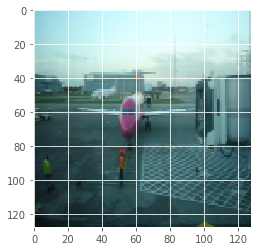

In [12]:
plt.imshow(X[0])

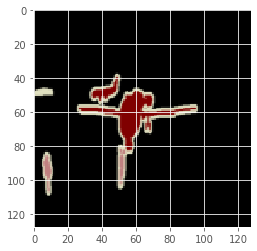

In [13]:
plt.imshow(y[0])

In [14]:
def segnet(inputs, n_classes):
    
    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Up Block 1
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 2
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 3
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 4
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Up Block 5
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = Conv2D(n_classes, (1, 1), activation='linear', padding='same')(x)
    
    return x

In [15]:
def train():
    model = get_model()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('model_weights_'+loss_name+'.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

    history = model.fit_generator(
        generator=batch_generator(batch_size),
        nb_epoch=epochs,
        samples_per_epoch=100,
        validation_data=batch_generator(batch_size),
        nb_val_samples=10,
        verbose=1,
        shuffle=False,
        callbacks=callbacks)

In [32]:
def get_model():
    NUMBER_OF_CLASSES=20
    inputs = Input((128, 128, 3))
    
    base = segnet(inputs, NUMBER_OF_CLASSES)
    
    # sigmoid
    reshape= Reshape((-1,NUMBER_OF_CLASSES))(base)
    act = Activation('sigmoid')(reshape)
    
    model = Model(inputs=inputs, outputs=act)
    model.compile(optimizer=Adadelta(), loss='binary_crossentropy')
    
    #print(model.summary())
    #sys.exit()
    
    return model

In [28]:
get_model()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
______________________________

In [34]:
def batch_generator(batch_size):
    while True:
        image_list = []
        mask_list = []
        for i in range(batch_size):
            img, mask = gen_random_image()
            image_list.append(img)
            mask_list.append(mask)

        image_list = np.array(image_list, dtype=np.float32) #Note: don't scale input, because use batchnorm after input
        mask_list = np.array(mask_list, dtype=np.float32)
        mask_list /= 255.0 # [0,1]
        
        mask_list= mask_list.reshape(batch_size,IMAGE_H*IMAGE_W,NUMBER_OF_CLASSES)
                
        yield image_list, mask_list

In [38]:
def gen_random_image():
    img = np.zeros((IMAGE_H, IMAGE_W, INPUT_CHANNELS), dtype=np.uint8)
    mask = np.zeros((IMAGE_H, IMAGE_W, NUMBER_OF_CLASSES), dtype=np.uint8)
    mask_obj1 = np.zeros((IMAGE_H, IMAGE_W, 1), dtype=np.uint8)
    mask_obj2 = np.zeros((IMAGE_H, IMAGE_W, 1), dtype=np.uint8)
    
    colors = np.random.permutation(256)
    
    # Background
    img[:, :, 0] = colors[0]
    img[:, :, 1] = colors[1]
    img[:, :, 2] = colors[2]

    # Object class 1
    obj1_color0 = colors[3]
    obj1_color1 = colors[4]
    obj1_color2 = colors[5]
    while(True):
        center_x = rn.randint(0, IMAGE_W)
        center_y = rn.randint(0, IMAGE_H)
        r_x = rn.randint(10, 50)
        r_y = rn.randint(10, 50)
        if(center_x+r_x < IMAGE_W and center_x-r_x > 0 and center_y+r_y < IMAGE_H and center_y-r_y > 0):
            cv2.ellipse(img, (int(center_x), int(center_y)), (int(r_x), int(r_y)), int(0), int(0), int(360), (int(obj1_color0), int(obj1_color1), int(obj1_color2)), int(-1))
            cv2.ellipse(mask_obj1, (int(center_x), int(center_y)), (int(r_x), int(r_y)), int(0), int(0), int(360), int(255), int(-1))
            break
    
    # Object class 2
    obj2_color0 = colors[6]
    obj2_color1 = colors[7]
    obj2_color2 = colors[8]
    while(True):
        left = rn.randint(0, IMAGE_W)
        top = rn.randint(0, IMAGE_H)
        dw = rn.randint(int(10*math.pi), int(50*math.pi))
        dh = rn.randint(int(10*math.pi), int(50*math.pi))
        if(left+dw < IMAGE_W and top+dh < IMAGE_H):
            mask_obj2 = np.zeros((IMAGE_H, IMAGE_W, 1), dtype=np.uint8)
            cv2.rectangle(mask_obj2, (left, top), (left+dw, top+dh), 255, -1)
            if(np.sum(cv2.bitwise_and(mask_obj1,mask_obj2)) == 0):
                cv2.rectangle(img, (left, top), (left+dw, top+dh), (obj2_color0, obj2_color1, obj2_color2), -1)
                break
            
    mask[:,:,0] = np.squeeze(mask_obj1)
    mask[:,:,1] = np.squeeze(mask_obj2)
    
    # White noise
    density = rn.uniform(0, 0.1)
    for i in range(IMAGE_H):
        for j in range(IMAGE_W):
            if rn.random() < density:
                img[i, j, 0] = rn.randint(0, 255)
                img[i, j, 1] = rn.randint(0, 255)
                img[i, j, 2] = rn.randint(0, 255)

    return img, mask

In [37]:
patience = 60
batch_size = 8
epochs = 10
loss_name = "binary_crossentropy"
train()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=<generator..., verbose=1, shuffle=False, callbacks=[<keras.ca..., steps_per_epoch=100, epochs=10, validation_steps=10)`



Epoch 1/10


NameError: name 'gen_random_image' is not defined